<a href="https://colab.research.google.com/github/MikChristensen/Algo-Trading-Examples/blob/main/Time_series_classification_algorithm_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Readings:

https://omdena.com/blog/time-series-classification-model-tutorial/
https://www.kaggle.com/code/szaitseff/classification-of-time-series-with-lstm-rnn


https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/

# Time series classification algorithms test
This project is about to test the most common algorithms for time series classification.
https://medium.com/mlearning-ai/all-8-types-of-time-series-classification-methods-2c8e4b323ea2


The list of algorithms will include:
- 1. Distance-Based Methods
- 2. Interval- and Frequency-Based Methods
- 3. Dictionary-Based Methods
- 4. Shapelet-Based Methods
- 5. Kernel-Based Methods
- 6. Feature-Based Methods
- 7. Model Ensembles
- 8. Deep Learning Methods (LSTM)

### Import packages

In [1]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib

--2023-08-12 18:28:12--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-08-12 18:28:13--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://onboardcloud.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-08-12 18:28:13--  http://onboardcloud.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving onboa

In [2]:
# Packages

import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Preprocessing data
from talib import abstract
import seaborn as sns   # plotting heatmap
import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.12.0


<ipython-input-2-840bb103d2f7>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Prepare data sets for algorithm test

### Load data from YFinance

In [3]:
# Data download
symbol = "EURUSD=X"
period ='60d'
interval ='15m'

[*********************100%***********************]  1 of 1 completed


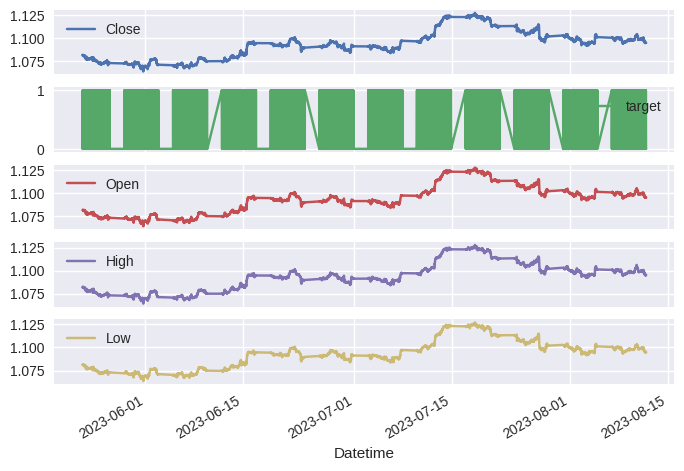

In [4]:
# Define function for downloading finance data from yfinance

def get_yfinance_hist(symbol = "EURUSD=X", period ='1mo', interval ='15m', show_plot = True ):
    df_raw = yf.download(symbol,period= period ,interval=interval)
    df_raw["returns"] = np.log(df_raw.Close.div(df_raw.Close.shift(1)))
    df_raw.dropna(how="any",inplace=True)
    df_raw["target"] = np.where(df_raw["returns"].shift(-1) > 0, 1, 0)
    df_raw = df_raw.drop('Volume', axis=1)

    if(show_plot):
      plot_cols = ['Close', 'target', 'Open', 'High', 'Low']
      plot_features = df_raw[plot_cols]
      plot_features.index = df_raw.index
      _ = plot_features.plot(subplots=True)

    return df_raw


df = get_yfinance_hist(symbol = symbol, period = period, interval= interval )

### Fetures function

In [5]:
def create_feature(data):
  # SD based features
  for i in range(5, 20, 5):
      col_name = 'std_' + str(i)
      data[col_name] = data['Close'].rolling(window=i).std()

  # MA based features
  '''
  for i in range(10, 30, 5):
      col_name = 'ma_' + str(i)
      data[col_name] = data['Close'].rolling(window=i).mean()
  '''
  # Daily pct change based features
  for i in range(3, 12, 3):
      col_name = 'pct_' + str(i)
      data[col_name] = data['Close'].pct_change().rolling(i).sum()

  # Intraday movement
  col_name = 'co'
  data[col_name] = data['Close'] - data['Open']

  #data['Ask_Dir'] = np.where(data['returns'].shift(-1) > data.returns, 1, 0)
  data['SMA'] = abstract.SMA(data['returns'], timeperiod=12)
  #data['SMA_Dir'] = np.where(data['SMA'].shift(-1) > data.SMA, 1, 0)
  data['RSI'] = abstract.RSI(data['returns'], timeperiod=12)
  #data['RSI_Dir'] = np.where(data['RSI'].shift(-1) > data.RSI, 1, 0)
  data['fastk'], data['fastd'] = abstract.STOCHRSI(data["returns"], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
  data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
  data["stochastic_k"], data["stochastic_d"] = talib.STOCH(data["High"], data["Low"], data["Close"], fastk_period=14, slowk_period=3, slowd_period=3)
  data.dropna(inplace = True)


  return data


df = create_feature(df)

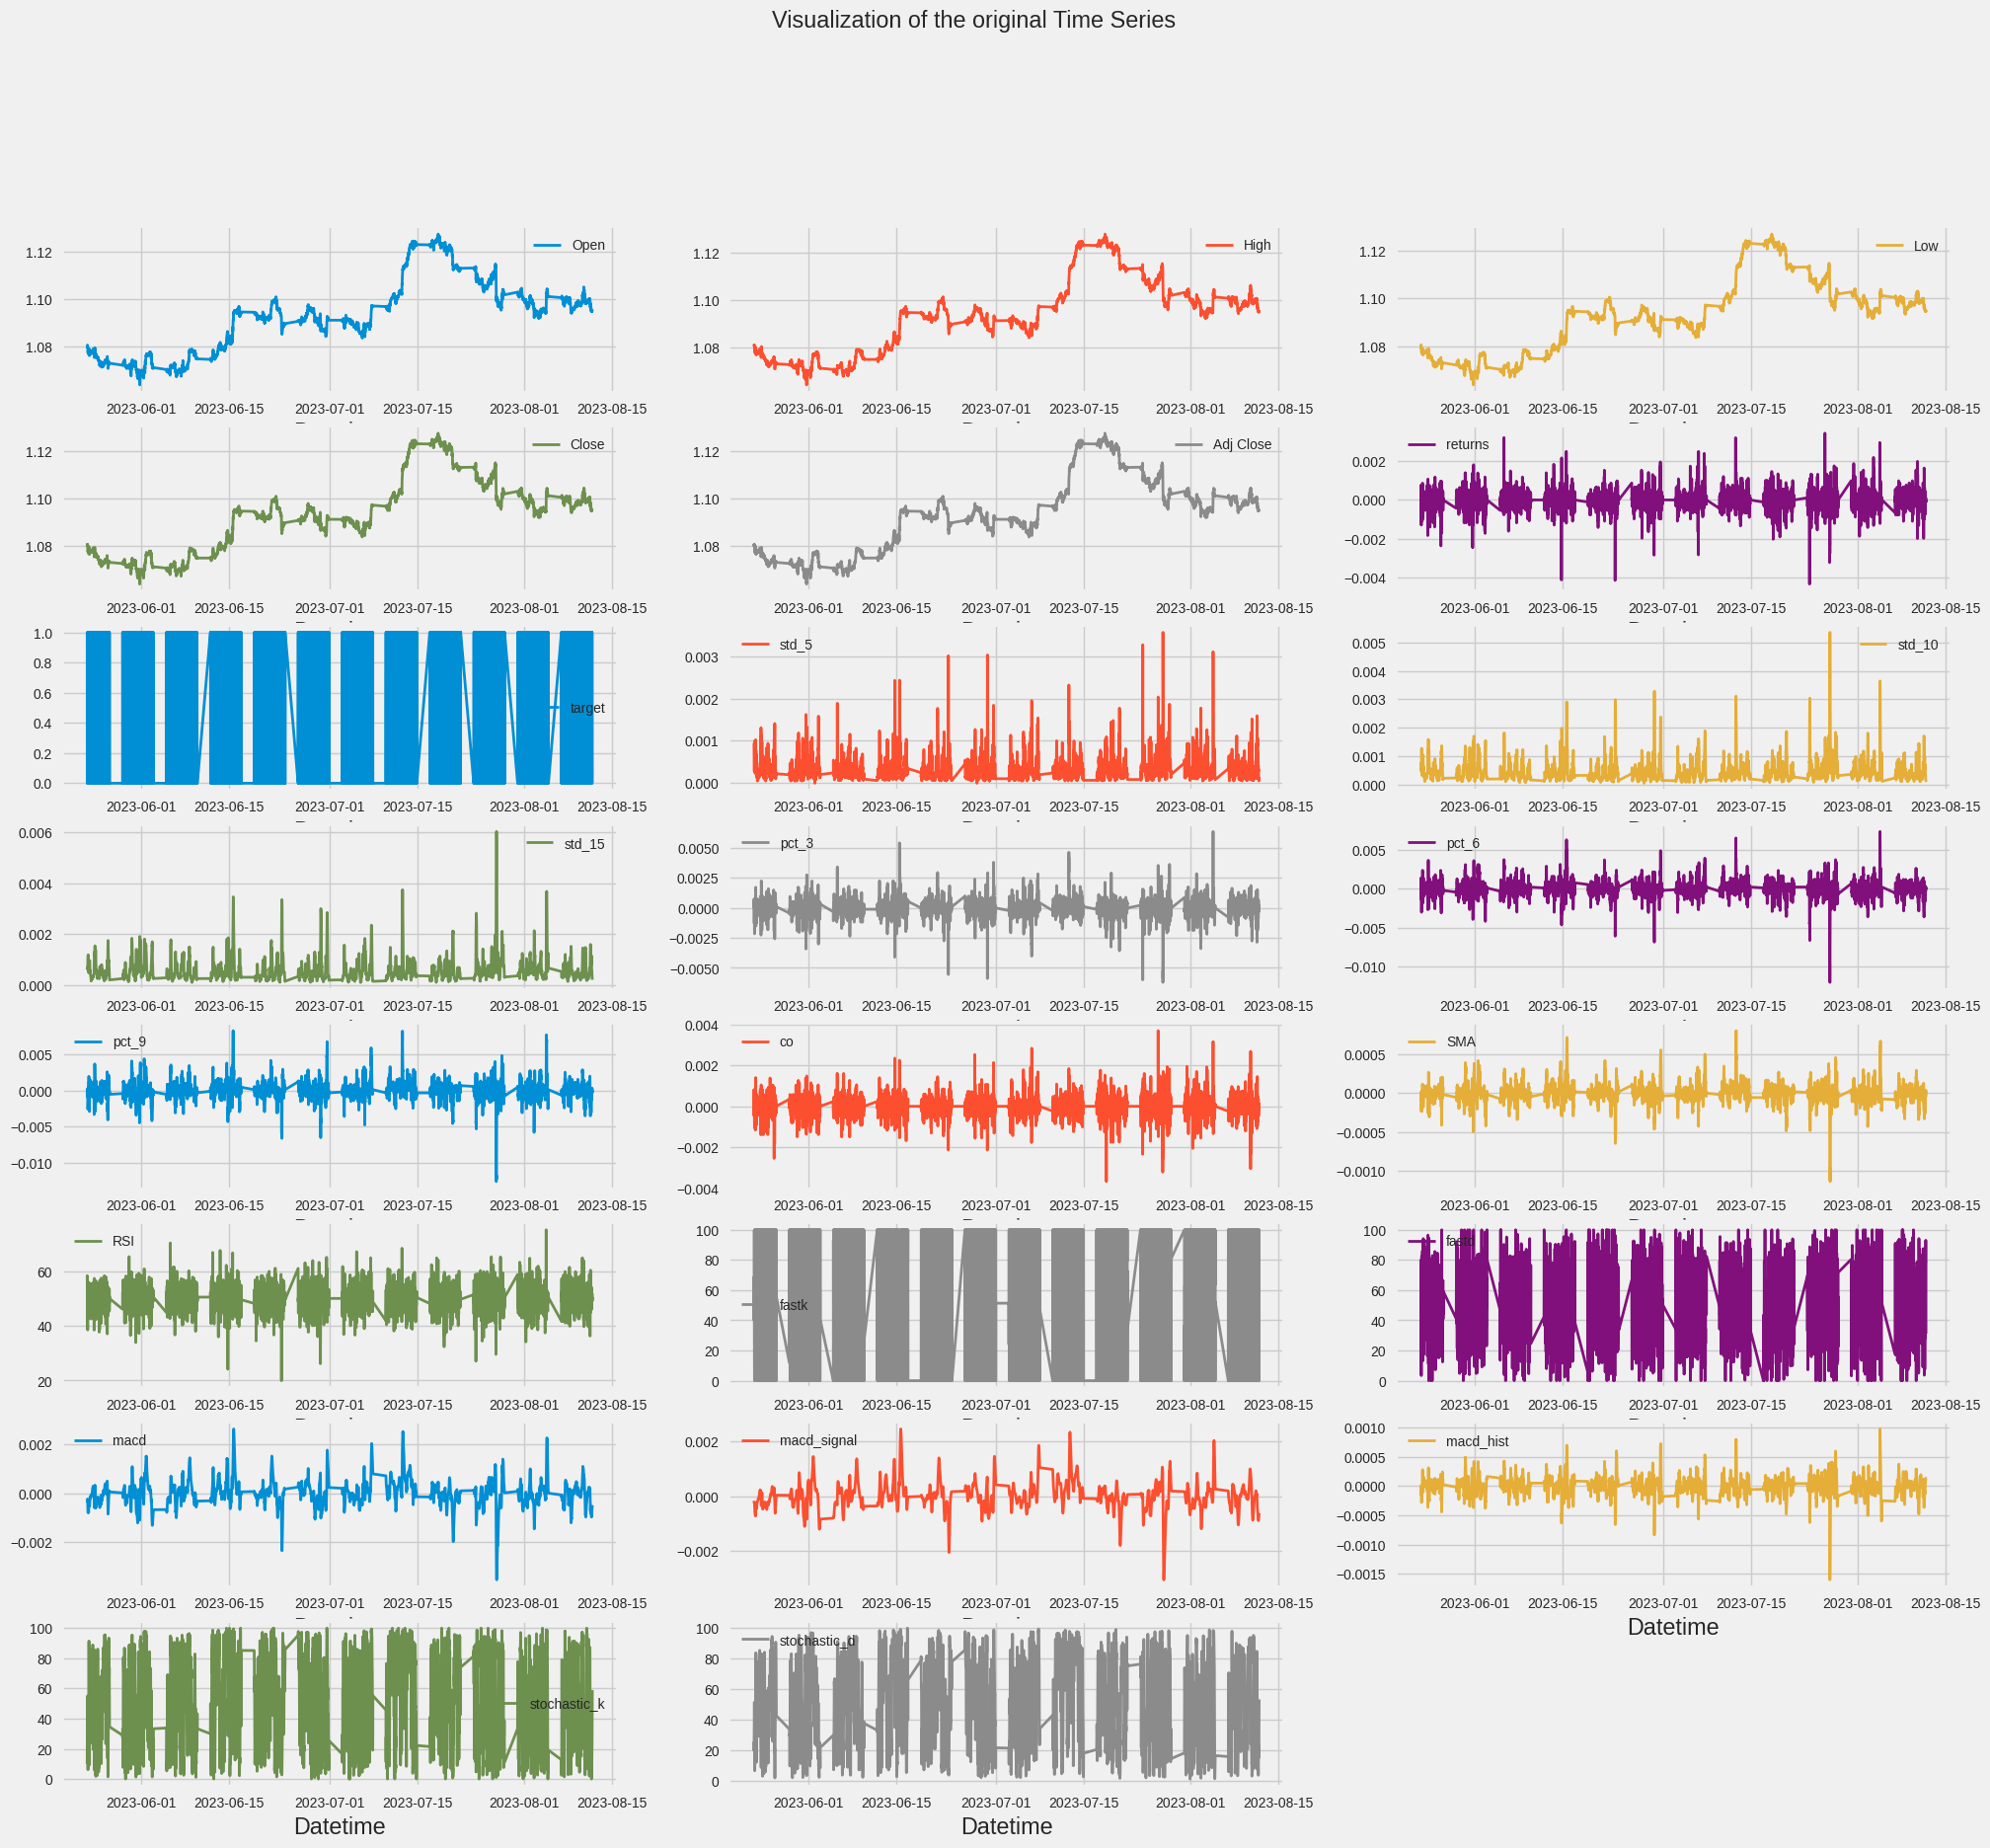

In [6]:
# Plot the time series
plt.style.use('fivethirtyeight')
df.plot(subplots=True,
        layout=(9, 3),
        figsize=(22,22),
        fontsize=10,
        linewidth=2,
        sharex=False,
        title='Visualization of the original Time Series')
plt.show()

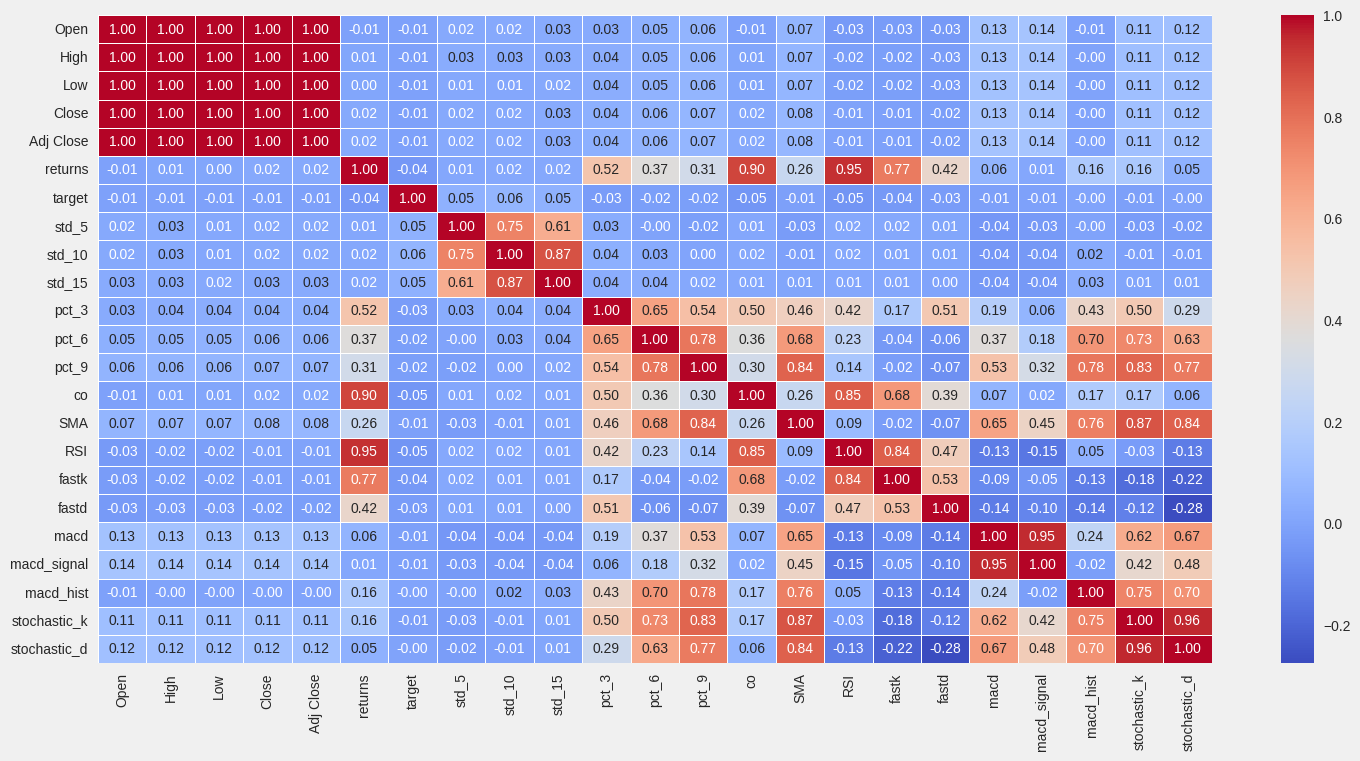

In [7]:
corr_matrix = df.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### Calculate normalized percentage change for all columns

In [8]:
'''Calculate percentage change'''

df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['Open', 'High', 'Low', 'Close']].min(axis=0))
max_return = max(df[['Open', 'High', 'Low', 'Close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['Open'] = (df['Open'] - min_return) / (max_return - min_return)
df['High'] = (df['High'] - min_return) / (max_return - min_return)
df['Low'] = (df['Low'] - min_return) / (max_return - min_return)
df['Close'] = (df['Close'] - min_return) / (max_return - min_return)

###############################################################################


In [9]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'returns', 'target',
       'std_5', 'std_10', 'std_15', 'pct_3', 'pct_6', 'pct_9', 'co', 'SMA',
       'RSI', 'fastk', 'fastd', 'macd', 'macd_signal', 'macd_hist',
       'stochastic_k', 'stochastic_d'],
      dtype='object')

### Split the df dataframe into test, train and validation dataset

In [10]:
df.columns.drop('target')

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'returns', 'std_5',
       'std_10', 'std_15', 'pct_3', 'pct_6', 'pct_9', 'co', 'SMA', 'RSI',
       'fastk', 'fastd', 'macd', 'macd_signal', 'macd_hist', 'stochastic_k',
       'stochastic_d'],
      dtype='object')

In [11]:
train_df, val_df, test_df = np.split(df.sample(frac=1, random_state=42),
                       [int(.6*len(df)), int(.8*len(df))])
X_cols = df.columns.drop('target')
y_cols = 'target'

df_X_train = train_df[X_cols]
df_y_train = train_df[y_cols]

df_X_val = val_df[X_cols]
df_y_val = val_df[y_cols]

df_X_test = test_df[X_cols]
df_y_test = test_df[y_cols]

In [12]:
X_cols

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'returns', 'std_5',
       'std_10', 'std_15', 'pct_3', 'pct_6', 'pct_9', 'co', 'SMA', 'RSI',
       'fastk', 'fastd', 'macd', 'macd_signal', 'macd_hist', 'stochastic_k',
       'stochastic_d'],
      dtype='object')

### Print the shapes of the datasets

In [13]:

# Convert pandas columns into arrays
train_data = train_df.values
val_data = val_df.values
test_data = test_df.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))


Training data shape: (3334, 23)
Validation data shape: (1111, 23)
Test data shape: (1112, 23)


### Plot daily changes of close prices and volume

Text(0, 0.5, 'Normalized Closing Returns')

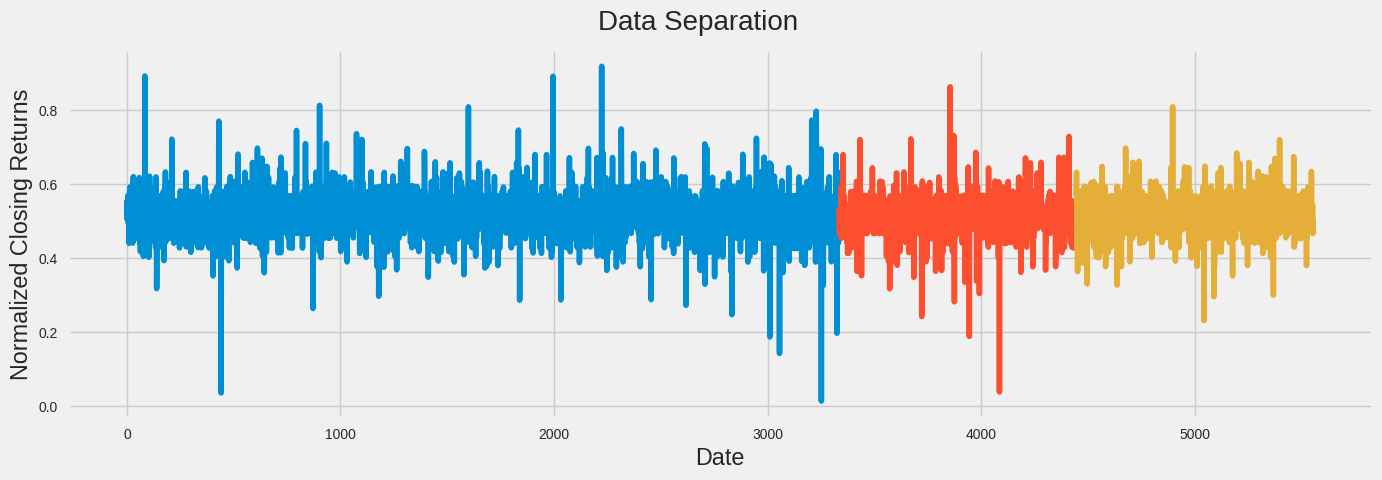

In [14]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.92)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), train_df['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]), val_df['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0],
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), test_df['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')


## 1. Distance-Based Methods

## 2. Interval- and Frequency-Based Methods

## 3. Dictionary-Based Methods

## 4. Shapelet-Based Methods

## 5. Kernel-Based Methods

## 6. Feature-Based Methods

## 7. Model Ensembles

## 8. Deep Learning Methods (LSTM)


### Create chunks of training, validation and test data

In [15]:
# Define hyper parameters
seq_len = 128

In [16]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(df_X_train[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(df_y_train[i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(df_X_val[i-seq_len:i])
    y_val.append(df_y_val[i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(df_X_test[i-seq_len:i])
    y_test.append(df_y_test[i])
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(3206, 128, 22) (3206,)
(983, 128, 22) (983,)


In [17]:
# Tensorflow model
epochs = 100

In [18]:
def Inception_A(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)

  branch5x5_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch5x5 = BatchNormalization()(branch5x5_1)
  branch5x5 = ReLU()(branch5x5)
  branch5x5 = Conv1D(c7, kernel_size=5, padding='same', use_bias=False)(branch5x5)
  branch5x5 = BatchNormalization()(branch5x5)
  branch5x5 = ReLU()(branch5x5)

  branch3x3_1 = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3_1)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)
  branch3x3 = Conv1D(c7, kernel_size=3, padding='same', use_bias=False)(branch3x3)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)

  branch_pool = AveragePooling1D(pool_size=(3), strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)
  outputs = Concatenate(axis=-1)([branch1x1, branch5x5, branch3x3, branch_pool])
  return outputs


def Inception_B(layer_in, c7):
  branch3x3 = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(layer_in)
  branch3x3 = BatchNormalization()(branch3x3)
  branch3x3 = ReLU()(branch3x3)

  branch3x3dbl = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", use_bias=False)(branch3x3dbl)
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)
  branch3x3dbl = Conv1D(c7, kernel_size=3, padding="same", strides=2, use_bias=False)(branch3x3dbl)
  branch3x3dbl = BatchNormalization()(branch3x3dbl)
  branch3x3dbl = ReLU()(branch3x3dbl)

  branch_pool = MaxPooling1D(pool_size=3, strides=2, padding="same")(layer_in)

  outputs = Concatenate(axis=-1)([branch3x3, branch3x3dbl, branch_pool])
  return outputs


def Inception_C(layer_in, c7):
  branch1x1_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch1x1 = BatchNormalization()(branch1x1_1)
  branch1x1 = ReLU()(branch1x1)

  branch7x7_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch7x7 = BatchNormalization()(branch7x7_1)
  branch7x7 = ReLU()(branch7x7)
  branch7x7 = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7)
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)
  branch7x7 = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7)
  branch7x7 = BatchNormalization()(branch7x7)
  branch7x7 = ReLU()(branch7x7)

  branch7x7dbl_1 = Conv1D(c7, kernel_size=1, padding="same", use_bias=False)(layer_in)
  branch7x7dbl = BatchNormalization()(branch7x7dbl_1)
  branch7x7dbl = ReLU()(branch7x7dbl)
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)
  branch7x7dbl = Conv1D(c7, kernel_size=(7), padding="same", use_bias=False)(branch7x7dbl)
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)
  branch7x7dbl = Conv1D(c7, kernel_size=(1), padding="same", use_bias=False)(branch7x7dbl)
  branch7x7dbl = BatchNormalization()(branch7x7dbl)
  branch7x7dbl = ReLU()(branch7x7dbl)

  branch_pool = AveragePooling1D(pool_size=3, strides=1, padding='same')(layer_in)
  branch_pool = Conv1D(c7, kernel_size=1, padding='same', use_bias=False)(branch_pool)
  branch_pool = BatchNormalization()(branch_pool)
  branch_pool = ReLU()(branch_pool)

  outputs = Concatenate(axis=-1)([branch1x1, branch7x7, branch7x7dbl, branch_pool])
  return outputs

### Create function for testing models

In [19]:
def run_model(model):
  model.summary()
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

  model.fit(X_train, y_train,
                batch_size=2048,
                verbose=2,
                callbacks=[callback],
                epochs=epochs,
                shuffle=True,
                validation_data=(X_val, y_val),)

  ###############################################################################
  '''Calculate predictions and metrics'''

  #Calculate predication for training, validation and test data
  train_pred = model.predict(X_train)
  val_pred = model.predict(X_val)
  test_pred = model.predict(X_test)

  #Print evaluation metrics for all datasets
  train_eval = model.evaluate(X_train, y_train, verbose=0)
  val_eval = model.evaluate(X_val, y_val, verbose=0)
  test_eval = model.evaluate(X_test, y_test, verbose=0)
  print(' ')
  print('Evaluation metrics')
  print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}, ACC: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2], train_eval[3]))
  print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}, ACC: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2] , val_eval[3]))
  print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}, ACC: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2], test_eval[3]))

  ###############################################################################
  '''Display results'''

  fig = plt.figure(figsize=(15,15))
  st = fig.suptitle("Bi-LSTM Model", fontsize=22)
  st.set_y(1.02)

  #Plot training data results
  ax11 = fig.add_subplot(311)
  ax11.plot(train_data[:, 0], label='Asset Closing price')
  ax11.plot(train_pred, color='yellow', linewidth=3, label='Predicted asset Closing Returns')
  ax11.set_title("Training Data", fontsize=18)
  ax11.set_xlabel('Date')
  ax11.set_ylabel('IBM Closing Returns')

  #Plot validation data results
  ax21 = fig.add_subplot(312)
  ax21.plot(val_data[:, 0], label='Asset Closing price')
  ax21.plot(val_pred, color='yellow', linewidth=3, label='Predicted Asset Closing Returns')
  ax21.set_title("Validation Data", fontsize=18)
  ax21.set_xlabel('Date')
  ax21.set_ylabel('IBM Closing Returns')

  #Plot test data results
  ax31 = fig.add_subplot(313)
  ax31.plot(test_data[:, 0], label='Asset Closing price')
  ax31.plot(test_pred, color='yellow', linewidth=3, label='Predicted Asset Closing Returns')
  ax31.set_title("Test Data", fontsize=18)
  ax31.set_xlabel('Date')
  ax31.set_ylabel('Asset Closing Returns')

  plt.tight_layout()
  plt.legend(loc='best')

In [20]:
def create_model_BI_LSTM():
  in_seq = Input(shape = (seq_len, len(X_cols)))

  x = Bidirectional(LSTM(128, return_sequences=True))(in_seq)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x)

  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="linear")(conc)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape', 'accuracy'])
  return model


In [21]:
def create_model_CNN_Bi_LSTM():
  in_seq = Input(shape=(seq_len, len(X_cols)))

  x = Inception_A(in_seq, 32)
  x = Inception_A(x, 32)
  x = Inception_B(x, 32)
  x = Inception_B(x, 32)
  x = Inception_C(x, 32)
  x = Inception_C(x, 32)

  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(128, return_sequences=True))(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x)

  avg_pool = GlobalAveragePooling1D()(x)
  max_pool = GlobalMaxPooling1D()(x)
  conc = concatenate([avg_pool, max_pool])
  conc = Dense(64, activation="relu")(conc)
  out = Dense(1, activation="sigmoid")(conc)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape', 'accuracy'])
  return model


80 128 22


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 80)           32960     
                                                                 
 lstm_1 (LSTM)               (None, 128, 240)          308160    
                                                                 
 lstm_2 (LSTM)               (None, 128, 240)          461760    
                                                                 
 lstm_3 (LSTM)               (None, 128, 80)           102720    
                                                                 
 lstm_4 (LSTM)               (None, 128, 80)           51520     
                                                                 
 dropout (Dropout)           (None, 128, 80)           0         
                                                                 
 lstm_5 (LSTM)               (None, 80)                5

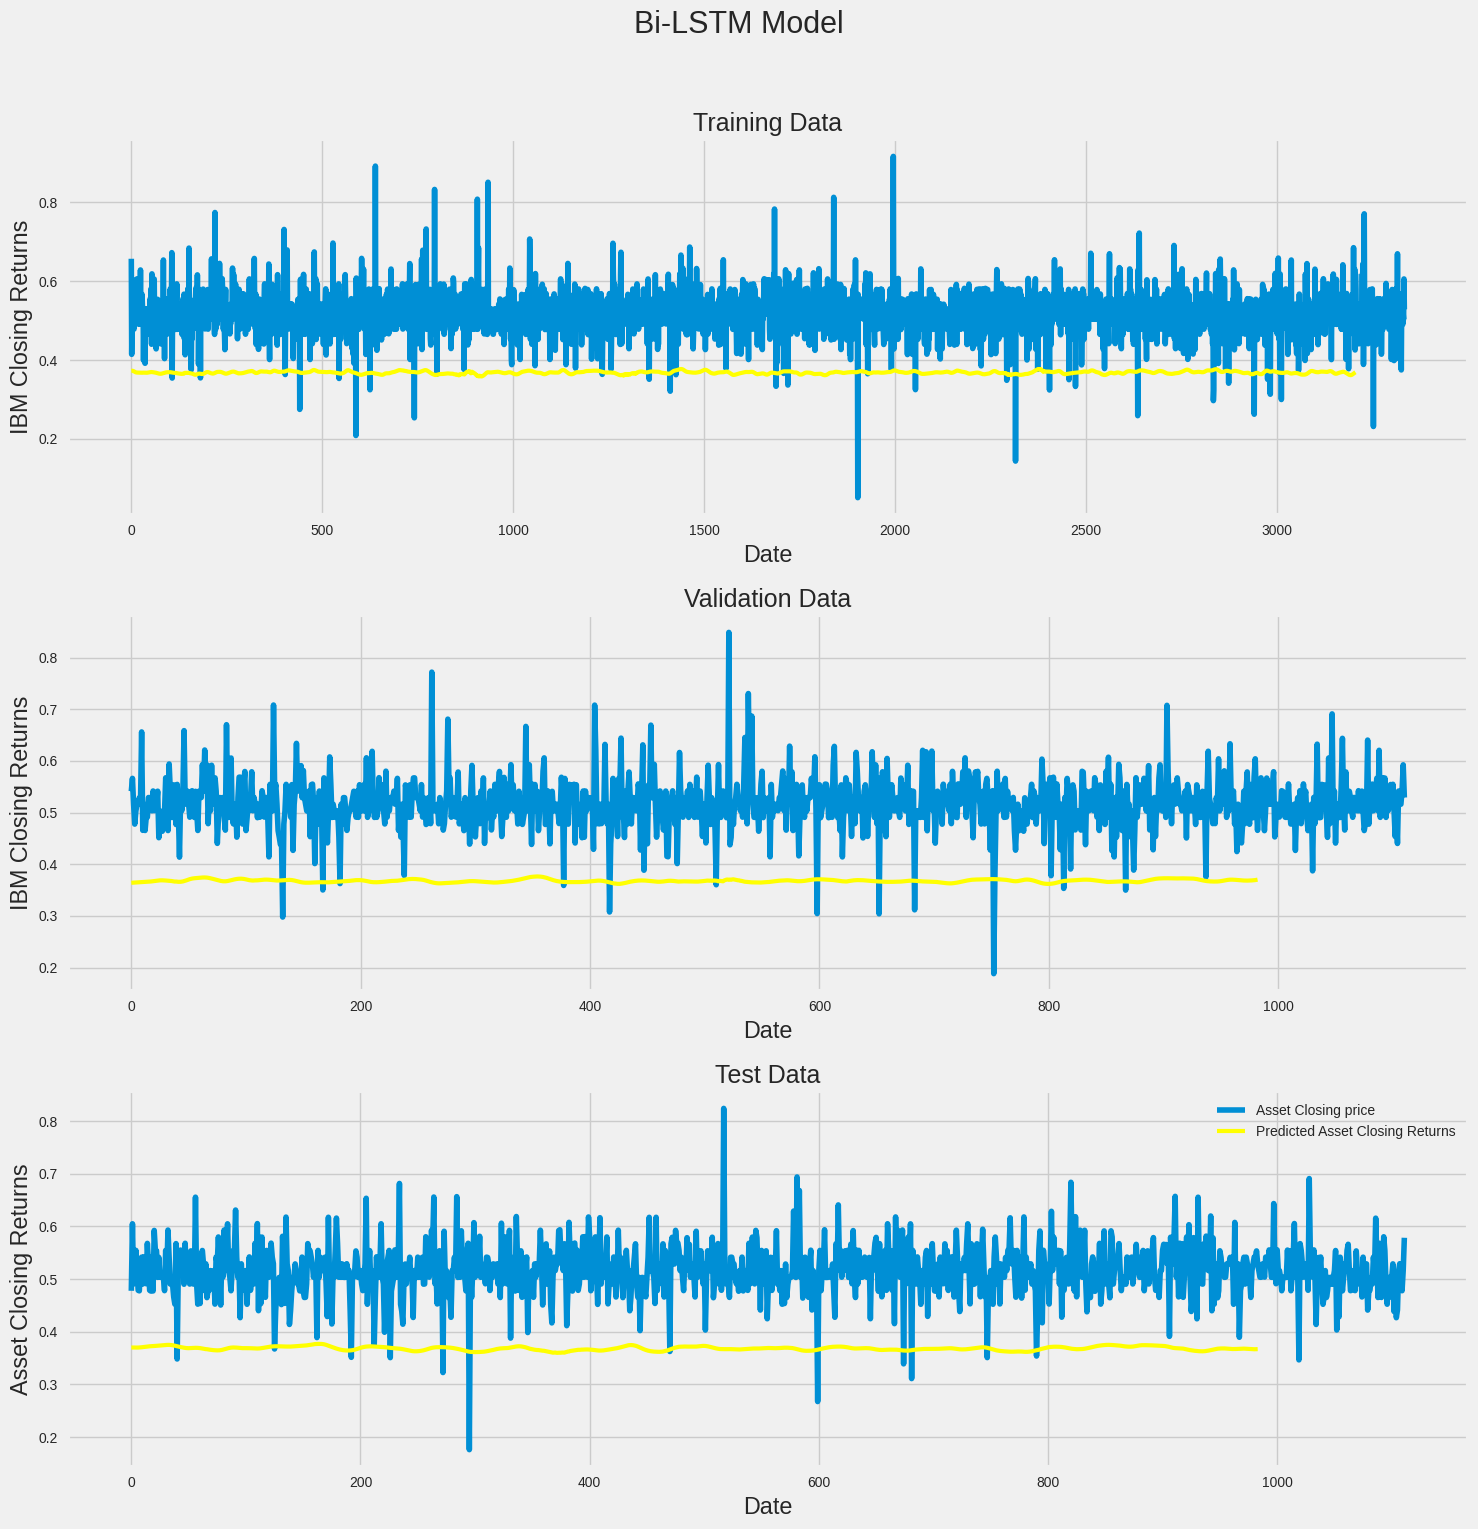

In [22]:
def create_model_LSTM():
  model = Sequential()

  # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
  #n_neurons = x_train.shape[1] * x_train.shape[2]
  n_neurons = 80
  print(n_neurons, X_train.shape[1], X_train.shape[2])
  model.add(LSTM(n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(LSTM(n_neurons * 3, return_sequences=True, activation='relu'))
  model.add(LSTM(n_neurons * 3, return_sequences=True, activation='relu'))
  model.add(LSTM(n_neurons, return_sequences=True, activation='relu'))
  model.add(LSTM(n_neurons, return_sequences=True, activation='relu'))
  model.add(Dropout(0.2))
  model.add(LSTM(n_neurons, return_sequences=False))
  model.add(Dense(n_neurons))
  model.add(Dense(n_neurons))
  model.add(Dense(5))
  model.add(Dense(1))



  model.compile(loss="mse", optimizer="adam", metrics=['mae', 'mape', 'accuracy'])
  return model

model_LSTM = create_model_LSTM()
run_model(model_LSTM)


### Run models

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 22)]    0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 128, 256)     154624      ['input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 128, 256)    394240      ['bidirectional[0][0]']          
 )                                                                                                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 128, 128)    164352      ['bidirectional_1[0][0]']    

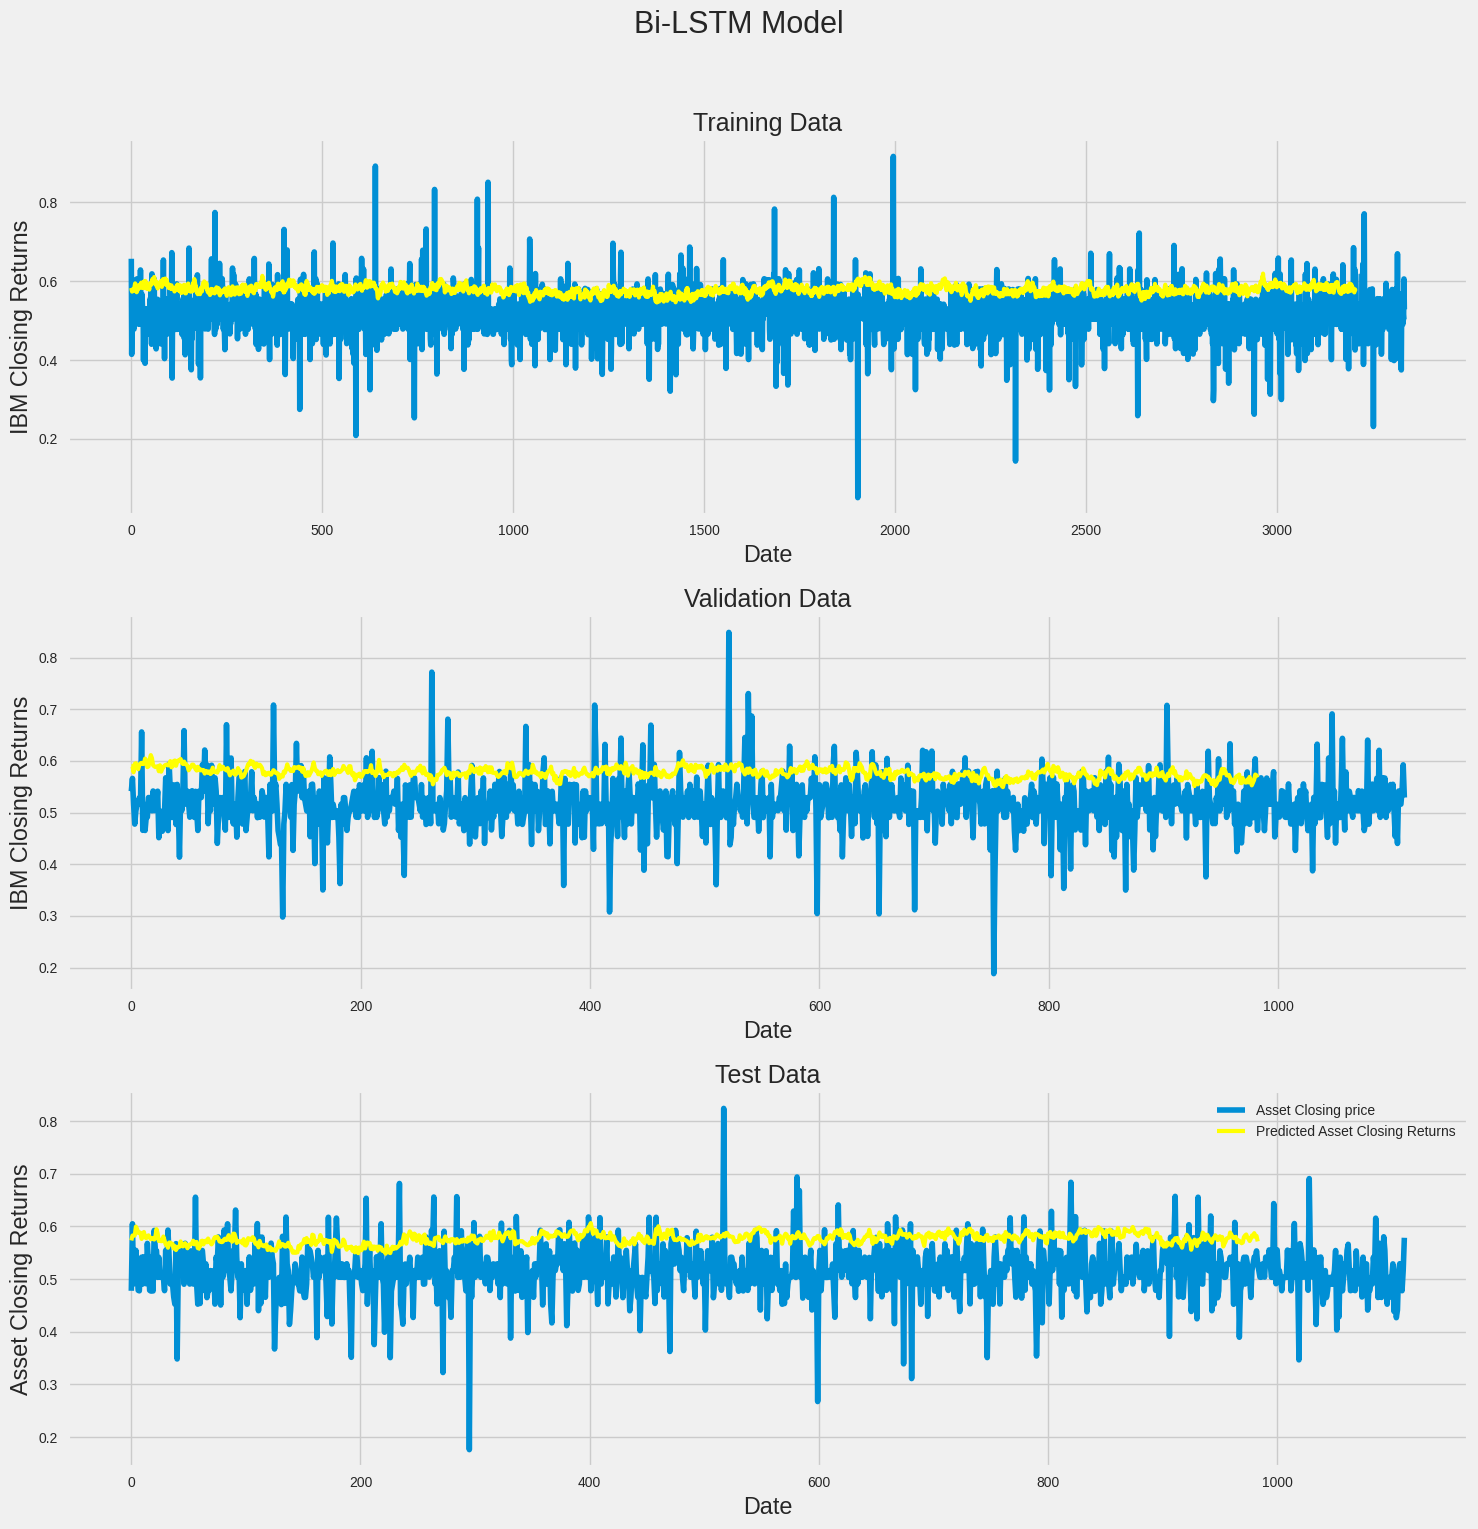

In [23]:

model_BI_LSTM = create_model_BI_LSTM()
run_model(model_BI_LSTM)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 22)]    0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 128, 32)      704         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 128, 32)     128         ['conv1d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 re_lu_3 (ReLU)                 (None, 128, 32)      0           ['batch_normalization_3[0][

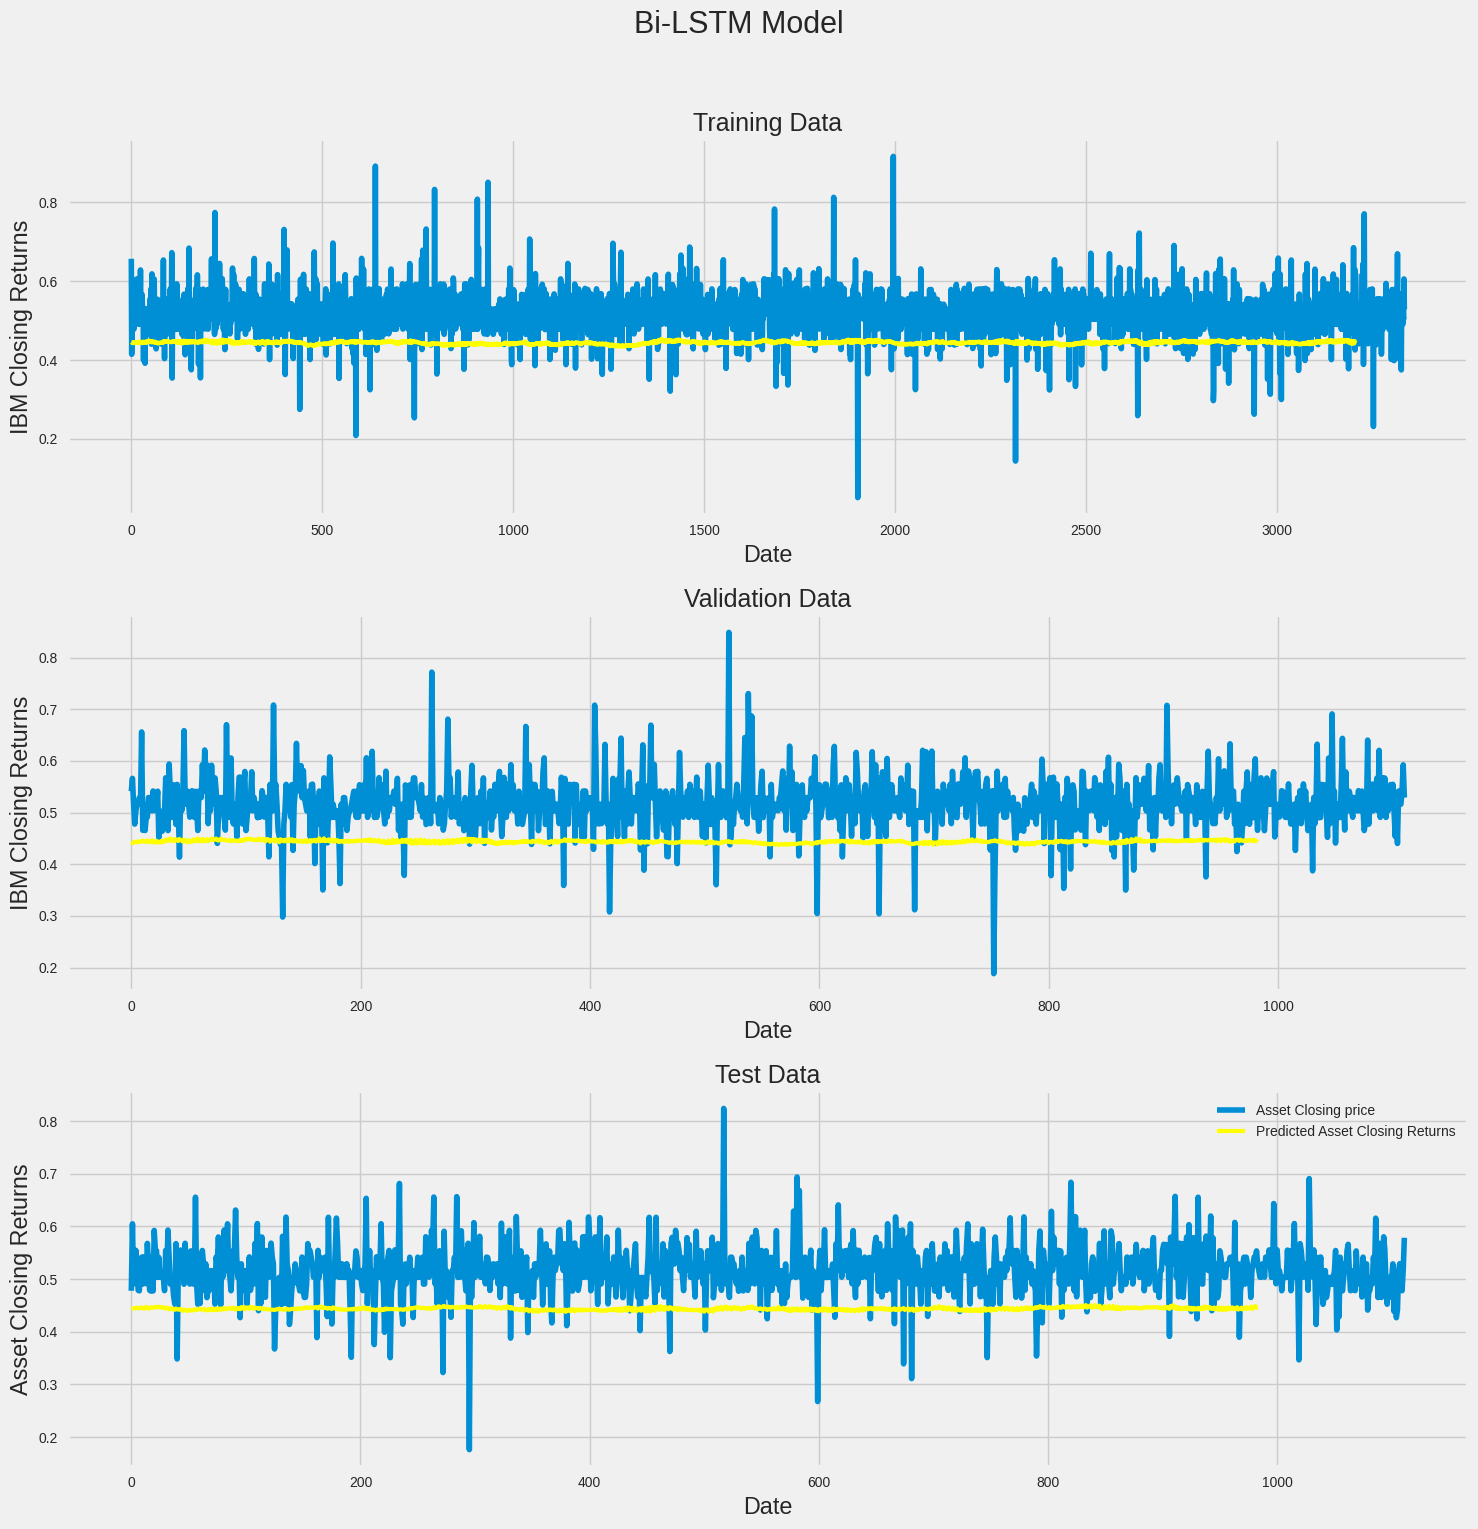

In [24]:
model_CNN_Bi_LSTM = create_model_CNN_Bi_LSTM()
run_model(model_CNN_Bi_LSTM)